In [5]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

In [6]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_texts = df_train[data_label].astype(str)
valid_texts = df_valid[data_label].astype(str)
test_texts = df_test[data_label].astype(str)

In [7]:
# Initialize the label encoder
all_labels = pd.concat([df_train[predict_label], df_valid[predict_label], df_test[predict_label]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
# Fit label encoder and return encoded labels as integers
train_labels_enc = label_encoder.transform(df_train[predict_label])
valid_labels_enc = label_encoder.transform(df_valid[predict_label])
test_labels_enc = label_encoder.transform(df_test[predict_label])

# Convert labels to categorical one-hot encoding
train_labels = to_categorical(train_labels_enc)
valid_labels = to_categorical(valid_labels_enc)
test_labels = to_categorical(test_labels_enc)

num_classes = len(df_train[predict_label].unique())

In [8]:
# Load spaCy model
nlp = spacy.load('de_core_news_sm')

def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text)
    doc = nlp(text)
    stop_words = spacy.lang.de.stop_words.STOP_WORDS
    words = [token.text for token in doc if token.text.lower() not in stop_words and token.is_alpha]
    return words

def get_word2vec_embeddings(text, model, vector_size=300):
    tokens = preprocess_text(text)
    embeddings = np.zeros((len(tokens), vector_size))
    for i, token in enumerate(tokens):
        if token in model.wv:
            embeddings[i] = model.wv[token]
        else:
            embeddings[i] = np.zeros(vector_size)
    return embeddings

# Load pre-trained Word2Vec embeddings
w2v = Word2Vec.load("../data/word2vec.model")

w2v_train_embeddings = [get_word2vec_embeddings(text, w2v) for text in train_texts]
w2v_valid_embeddings = [get_word2vec_embeddings(text, w2v) for text in valid_texts]
w2v_test_embeddings = [get_word2vec_embeddings(text, w2v) for text in test_texts]
max_length = max(len(embedding) for embedding in w2v_train_embeddings)
w2v_padded_train_embeddings = pad_sequences(w2v_train_embeddings, maxlen=max_length, padding='post', dtype='float32')
w2v_padded_valid_embeddings = pad_sequences(w2v_valid_embeddings, maxlen=max_length, padding='post', dtype='float32')
w2v_padded_test_embeddings = pad_sequences(w2v_test_embeddings, maxlen=max_length, padding='post', dtype='float32')

# Model parameters

In [9]:
embedding_dim = 300
lstm_units = 64
epochs = 15
batch_size = 32
model_name = "word2vec"

In [10]:
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(average="macro", name='f1_score'),
]
early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',  
    patience=3,         
    restore_best_weights=True,
    verbose=1
)

2024-07-28 14:27:45.307073: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-28 14:27:45.307113: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-28 14:27:45.307117: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-28 14:27:45.307130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-28 14:27:45.307141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [11]:
# Define the input layer
input_text = Input(shape=(max_length, embedding_dim), dtype='float32', name='text_input')

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(input_text)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
history = model.fit(w2v_padded_train_embeddings, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(w2v_padded_valid_embeddings, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-07-28 14:27:48.212614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 88s 117ms/step - accuracy: 0.4339 - auc: 0.7911 - f1_score: 0.1976 - loss: 1.2204 - val_accuracy: 0.4556 - val_auc: 0.8043 - val_f1_score: 0.1978 - val_loss: 1.1913
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 91s 123ms/step - accuracy: 0.4598 - auc: 0.8092 - f1_score: 0.2268 - loss: 1.1757 - val_accuracy: 0.4552 - val_auc: 0.8088 - val_f1_score: 0.2485 - val_loss: 1.1791
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 90s 122ms/step - accuracy: 0.4755 - auc: 0.8180 - f1_score: 0.2505 - loss: 1.1548 - val_accuracy: 0.4721 - val_auc: 0.8144 - val_f1_score: 0.2197 - val_loss: 1.1659
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 92s 125ms/step - accuracy: 0.4812 - auc: 0.8216 - f1_score: 0.2543 - loss: 1.1475 - val_accuracy: 0.4728 - val_auc: 0.8138 - val_f1_score: 0.2202 - val_loss: 1.1759
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 92s 125ms/step - accuracy: 0.4959 - auc: 0.8279 - f1_score: 0.2721 - loss: 1.1339 - val_accuracy: 0.4492 - val_auc: 0.8089 - val_f1_score: 0.2134 - val

In [13]:
save_for_evaluation(model, history, model_name, w2v_padded_test_embeddings, test_labels, label_encoder)

Model saved to ../models/lstm/word2vec/word2vec.h5
Data saved


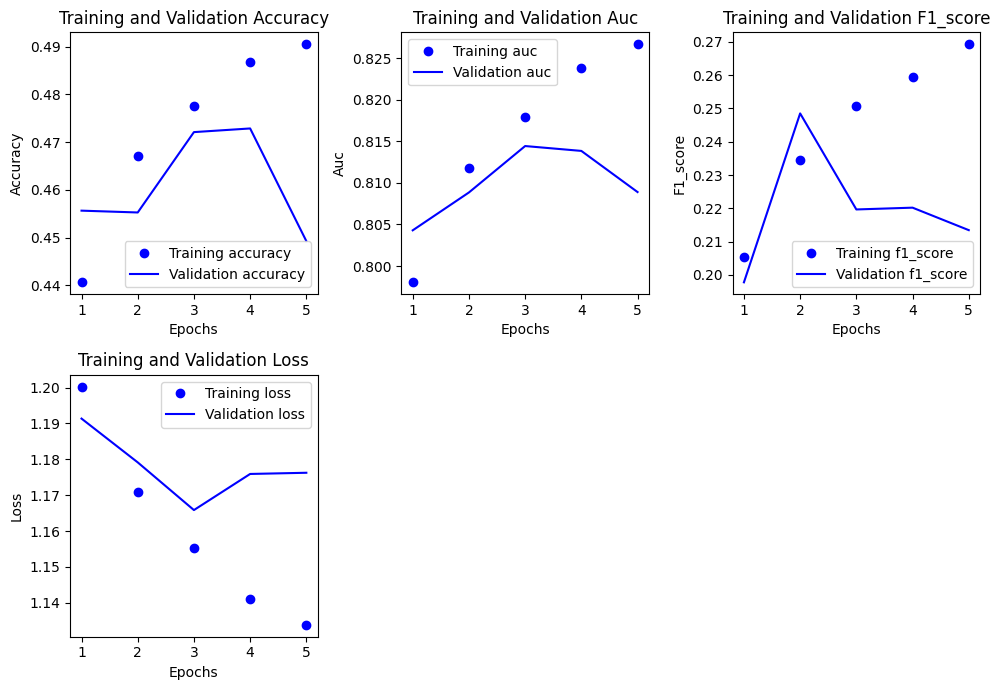

In [14]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


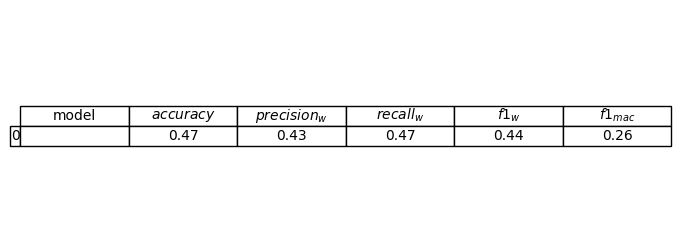

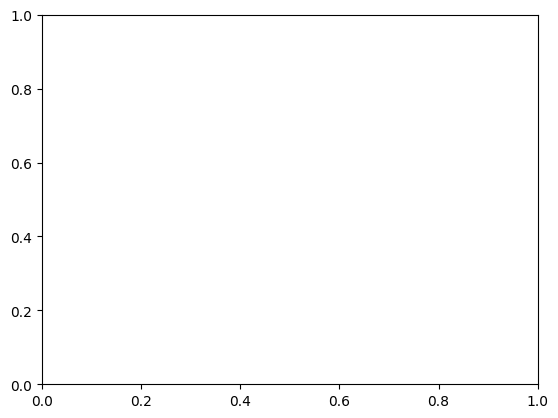

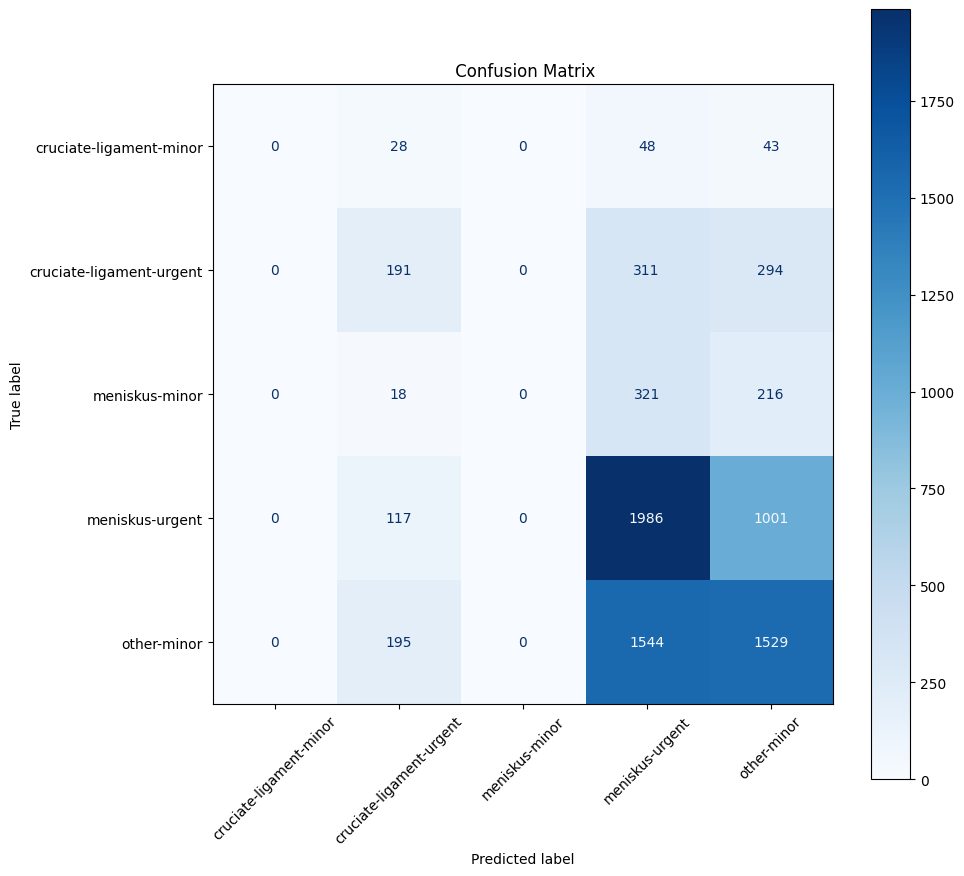

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.47,0.43,0.47,0.44,0.26


In [15]:
eval(model, w2v_padded_test_embeddings, test_labels, label_encoder)